In [1]:
import pandas as pd 
import numpy as np 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import KFold,StratifiedKFold

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve, fbeta_score, f1_score 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler

import imblearn.over_sampling


from sklearn.metrics import log_loss
from sklearn import metrics

import warnings
warnings.simplefilter(action='ignore')


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df= pd.read_csv('cleaned_dataset.csv')
df.head()

,heart_attack_disease,sex,age,race_ethn,bmi,overweight,diabetes,diagnose_strk,smoker,high_bp,high_chol,heavy_drinker,exercise,fruit,vege
0,0.0,1.0,70.0,0.0,15.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
1,1.0,1.0,67.0,1.0,28.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,1.0,1.0,72.0,1.0,28.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,62.0,0.0,33.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
4,1.0,0.0,76.0,5.0,29.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [3]:
df.heart_attack_disease.value_counts()

0.0    347607
1.0     33540
Name: heart_attack_disease, dtype: int64

In [4]:
df.heart_attack_disease.value_counts(normalize = True)

0.0    0.912002
1.0    0.087998
Name: heart_attack_disease, dtype: float64

In [5]:
#class is imbalanced , will use techniques to handle imbalance in order to improve metric scores

In [6]:
X = df.drop(['heart_attack_disease'], axis = 1)
y = df['heart_attack_disease']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.3, 
                                                    random_state=42, 
                                                   stratify = y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [8]:
X_train.shape

(266802, 14)

In [9]:
X_test.shape

(114345, 14)

In [10]:
y_train.value_counts()

0.0    243324
1.0     23478
Name: heart_attack_disease, dtype: int64

In [11]:
def make_confusion_matrix(model, threshold = 0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test_s)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no disease', 'disease'],
           yticklabels=['no disease', 'disease']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

Logistic
1a. Class Weight + GridSearchCV
1b. Oversampling + GridSearchCV
1c. SMOTE + GridSearchCV

In [12]:
#1a. Class weight + GridSearchCV
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_balanced = LogisticRegression(class_weight='balanced', 
                                 solver='liblinear')
grid_lr_weight = GridSearchCV(lr_balanced, param_grid = grid_values, cv=5,
                       scoring=['precision','recall','f1', 'roc_auc'], n_jobs=-1, 
                       return_train_score = True, refit = 'recall')
grid_lr_weight.fit(X_train_s, y_train)

lr_grid_pred = grid_lr_weight.predict(X_test_s)
lr_grid_best_para = grid_lr_weight.best_params_


In [13]:
print(lr_grid_best_para)

{'C': 0.001, 'penalty': 'l1'}


In [14]:
print(grid_lr_weight.best_estimator_.get_params())

{'C': 0.001, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [15]:
print(classification_report(y_test, lr_grid_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.70      0.82    104283
         1.0       0.20      0.79      0.32     10062

    accuracy                           0.71    114345
   macro avg       0.59      0.75      0.57    114345
weighted avg       0.90      0.71      0.77    114345



<AxesSubplot:>

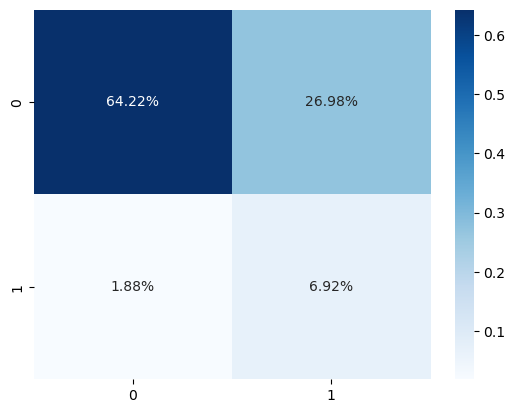

In [16]:
cf_matrix_lr = confusion_matrix(y_test, lr_grid_pred)
sns.heatmap(cf_matrix_lr/np.sum(cf_matrix_lr), annot=True, 
            fmt='.2%', cmap='Blues')

In [17]:
#retrain using best hyperparameters , score on test 
        
lr_weight_2 = LogisticRegression(C = 0.001, class_weight = 'balanced', 
                                 dual = False, fit_intercept = True, intercept_scaling = 1, 
                                 l1_ratio =  None, max_iter = 100, multi_class = 'auto', n_jobs = None, 
                                 penalty = 'l1',random_state =  None, solver = 'liblinear', tol =  0.0001, 
                                 verbose =  0, warm_start =  False)
lr_weight_2.fit(X_train_s, y_train)
lr_pred_weight = lr_weight_2.predict(X_test_s)

lr_acc_weight = lr_weight_2.score(X_test_s, y_test)
lr_precision_weight= precision_score(y_test, lr_pred_weight)
lr_recall_weight = recall_score(y_test, lr_pred_weight)
lr_f1_weight = f1_score(y_test, lr_pred_weight)

lr_fpr_weight, lr_tpr_weight, lr_thresholds_weight = roc_curve(y_test, lr_weight_2.predict_proba(X_test_s)[:,1])
roc_auc_lr_weight = auc(lr_fpr_weight,lr_tpr_weight)

print(f'Logistic Regression (Test) Class Weight: Accuracy: {lr_acc_weight:.6f}')
print(f'Logistic Regression (Test) Class Weight: Precision: {lr_precision_weight:.6f}')
print(f'Logistic Regression (Test) Class Weight: Recall : {lr_recall_weight:.6f}')
print(f'Logistic Regression (Test) Class Weight: F1 : {lr_f1_weight:.6f}')
print(f'Logistic Regression (Test) Class Weight: Roc : {roc_auc_lr_weight:.6f}')

Logistic Regression (Test) Class Weight: Accuracy: 0.711426
Logistic Regression (Test) Class Weight: Precision: 0.204148
Logistic Regression (Test) Class Weight: Recall : 0.786424
Logistic Regression (Test) Class Weight: F1 : 0.324151
Logistic Regression (Test) Class Weight: Roc : 0.817612


1b. Oversampling + GridSearchCV (Logistic Regression)

In [18]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

imb_ratio = int(n_neg/n_pos)
ratio = {1 : n_pos * imb_ratio, 0 : n_neg} 

ros = imblearn.over_sampling.RandomOverSampler(sampling_strategy= ratio, random_state = 44)
X_train_rs, y_train_rs = ros.fit_resample(X_train_s, y_train)

In [19]:
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}

lr_rs = LogisticRegression(solver='liblinear')
grid_lr_rs = GridSearchCV(lr_rs, param_grid = grid_values, cv=5,
                       scoring=['precision','recall','f1', 'roc_auc'], n_jobs=-1, 
                       return_train_score = True, refit = 'recall', verbose = 2)
grid_lr_rs.fit(X_train_rs, y_train_rs)

lr_grid_pred_rs = grid_lr_rs.predict(X_test_s)
lr_grid_best_para_rs = grid_lr_rs.best_params_


Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [20]:
print(lr_grid_best_para_rs)

{'C': 0.001, 'penalty': 'l1'}


In [21]:
print(grid_lr_rs.best_estimator_.get_params())

{'C': 0.001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [22]:
print(classification_report(y_test, lr_grid_pred_rs))

              precision    recall  f1-score   support

         0.0       0.97      0.72      0.82    104283
         1.0       0.21      0.77      0.33     10062

    accuracy                           0.72    114345
   macro avg       0.59      0.74      0.58    114345
weighted avg       0.90      0.72      0.78    114345



<AxesSubplot:>

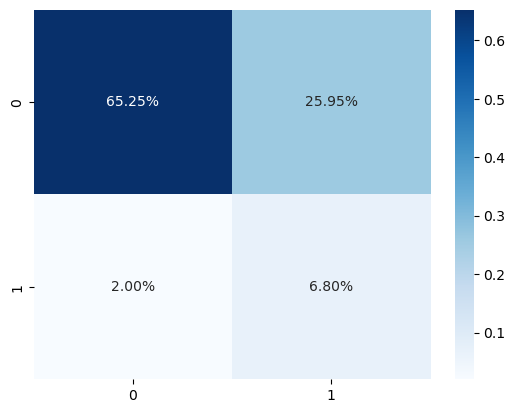

In [23]:
cf_matrix_lr_rs = confusion_matrix(y_test, lr_grid_pred_rs)
sns.heatmap(cf_matrix_lr_rs/np.sum(cf_matrix_lr_rs), annot=True, 
            fmt='.2%', cmap='Blues')

In [24]:
#train using best hyperparameters , test 
lr_rs_2 = LogisticRegression(C = 0.001, class_weight = None, dual = False, 
                             fit_intercept = True, intercept_scaling = 1, l1_ratio = None,
                             max_iter = 100, multi_class = 'auto', n_jobs = None, penalty= 'l1',
                             random_state = None, solver = 'liblinear', tol = 0.0001, 
                             verbose = 0, warm_start = False)
lr_rs_2.fit(X_train_rs, y_train_rs)
lr_pred_rs_2 = lr_rs_2.predict(X_test_s)

lr_acc_os = lr_rs_2.score(X_test_s, y_test)
lr_precision_os= precision_score(y_test, lr_pred_rs_2)
lr_recall_os = recall_score(y_test, lr_pred_rs_2)
lr_f1_os = f1_score(y_test, lr_pred_rs_2)

lr_fpr_os, lr_tpr_os, lr_thresholds_os = roc_curve(y_test, lr_rs_2.predict_proba(X_test_s)[:,1])
roc_auc_lr_os = auc(lr_fpr_os,lr_tpr_os)

print(f'Logistic Regression (Test) Oversampling: Accuracy: {lr_acc_os:.6f}')
print(f'Logistic Regression (Test) Oversampling: Precision: {lr_precision_os:.6f}')
print(f'Logistic Regression (Test) Oversampling: Recall : {lr_recall_os:.6f}')
print(f'Logistic Regression (Test) Oversampling: F1 : {lr_f1_os:.6f}')
print(f'Logistic Regression (Test) Oversampling: Roc : {roc_auc_lr_os:.6f}')

Logistic Regression (Test) Oversampling: Accuracy: 0.720443
Logistic Regression (Test) Oversampling: Precision: 0.207541
Logistic Regression (Test) Oversampling: Recall : 0.772411
Logistic Regression (Test) Oversampling: F1 : 0.327173
Logistic Regression (Test) Oversampling: Roc : 0.817695


1c. SMOTE + RandomizedSearchCV

In [25]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

imb_ratio = int(n_neg/n_pos)
ratio = {1 : n_pos * imb_ratio, 0 : n_neg} 

smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
   
X_train_smote, y_train_smote = smote.fit_resample(X_train_s, y_train)

In [26]:
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_smote = LogisticRegression(solver='liblinear')
grid_lr_smote = GridSearchCV(lr_smote, param_grid = grid_values, cv=5,
                       scoring=['precision','recall','f1', 'roc_auc'], n_jobs=-1, 
                       return_train_score = True, refit = 'recall', verbose = 2)
grid_lr_smote.fit(X_train_smote, y_train_smote)

lr_grid_pred_smote = grid_lr_smote.predict(X_test_s)
lr_grid_best_para_smote = grid_lr_smote.best_params_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [27]:
print(lr_grid_best_para_smote)

{'C': 0.001, 'penalty': 'l1'}


In [28]:
print(grid_lr_smote.best_estimator_.get_params())

{'C': 0.001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [29]:
print(classification_report(y_test, lr_grid_pred_smote))

              precision    recall  f1-score   support

         0.0       0.97      0.72      0.82    104283
         1.0       0.21      0.77      0.33     10062

    accuracy                           0.72    114345
   macro avg       0.59      0.74      0.58    114345
weighted avg       0.90      0.72      0.78    114345



<AxesSubplot:>

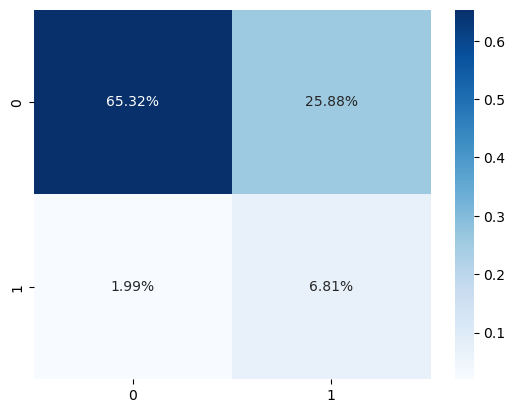

In [30]:
cf_matrix_lr_smote = confusion_matrix(y_test, lr_grid_pred_smote)
sns.heatmap(cf_matrix_lr_smote/np.sum(cf_matrix_lr_smote), annot=True, 
            fmt='.2%', cmap='Blues')

In [31]:
#retrain using best hyperparameters , test 
lr_smote_2 = LogisticRegression(C = 0.001, class_weight = None, dual = False, fit_intercept = True, 
                                intercept_scaling = 1, l1_ratio = None, max_iter = 100, 
                                multi_class = 'auto', n_jobs = None, penalty = 'l1',
                                random_state = None, solver = 'liblinear', tol = 0.0001, 
                                verbose = 0, warm_start = False)
lr_smote_2.fit(X_train_smote, y_train_smote)
lr_pred_smote_2 = lr_smote_2.predict(X_test_s)

lr_acc_smote = lr_smote_2.score(X_test_s, y_test)
lr_precision_smote= precision_score(y_test, lr_pred_smote_2)
lr_recall_smote = recall_score(y_test, lr_pred_smote_2)
lr_f1_smote = f1_score(y_test, lr_pred_smote_2)

lr_fpr_smote, lr_tpr_smote, lr_thresholds_smote = roc_curve(y_test, lr_smote_2.predict_proba(X_test_s)[:,1])
roc_auc_lr_smote = auc(lr_fpr_smote,lr_tpr_smote)

print(f'Logistic Regression (Test) Smote: Accuracy: {lr_acc_smote:.6f}')
print(f'Logistic Regression (Test) Smote: Precision: {lr_precision_smote:.6f}')
print(f'Logistic Regression (Test) Smote: Recall : {lr_recall_smote:.6f}')
print(f'Logistic Regression (Test) Smote: F1 : {lr_f1_smote:.6f}')
print(f'Logistic Regression (Test) Smote: Roc : {roc_auc_lr_smote:.6f}')

Logistic Regression (Test) Smote: Accuracy: 0.721300
Logistic Regression (Test) Smote: Precision: 0.208242
Logistic Regression (Test) Smote: Recall : 0.773405
Logistic Regression (Test) Smote: F1 : 0.328133
Logistic Regression (Test) Smote: Roc : 0.817285


Random Forest
1a. Class Weight + RandomizedSearchCV
1b. Oversampling + RandomizedSearchCV
1c. SMOTE + RandomizedSearchCV

In [32]:
#1a. Class weight + RandomizedSearchCV
grid_values_rf = {
    'bootstrap': [True, False],
    'min_samples_leaf': [1,2,4,8],
    'min_samples_split' : [2,4,5,10],
    'max_depth': [5,10,15,20],
    'criterion': ['gini','entropy'], 
    'n_estimators': [10, 50, 100, 150, 200, 300]}


rf_balanced = RandomForestClassifier(class_weight = 'balanced')
grid_rf_weight = RandomizedSearchCV(rf_balanced, param_distributions = grid_values_rf, cv=3,
                                    scoring=['precision','recall','f1', 'roc_auc'],
                                    n_jobs= -1, refit = 'recall',
                                    return_train_score = True,
                                    n_iter = 10)
grid_rf_weight.fit(X_train, y_train)

rf_grid_pred_weight = grid_rf_weight.predict(X_test)
rf_grid_best_para_weight = grid_rf_weight.best_params_

In [33]:
print(rf_grid_best_para_weight)

{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}


In [34]:
print(grid_rf_weight.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [35]:
print(classification_report(y_test, rf_grid_pred_weight))

              precision    recall  f1-score   support

         0.0       0.97      0.68      0.80    104283
         1.0       0.19      0.81      0.31     10062

    accuracy                           0.69    114345
   macro avg       0.58      0.74      0.55    114345
weighted avg       0.90      0.69      0.75    114345



<AxesSubplot:>

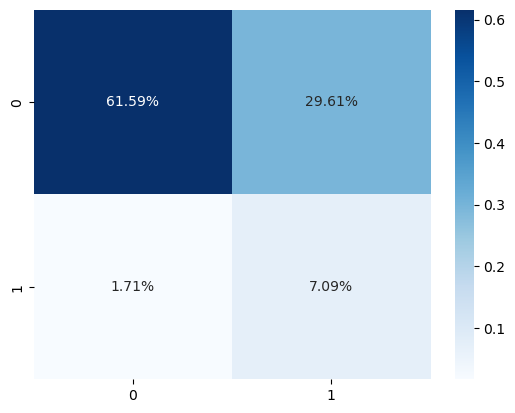

[CV] END ................................C=0.001, penalty=l1; total time=   4.1s
[CV] END ................................C=0.001, penalty=l1; total time=   2.9s
[CV] END .................................C=0.01, penalty=l1; total time=   3.4s
[CV] END .................................C=0.01, penalty=l2; total time=   2.9s
[CV] END .................................C=0.01, penalty=l2; total time=   3.9s
[CV] END ..................................C=0.1, penalty=l1; total time=   3.5s
[CV] END ..................................C=0.1, penalty=l2; total time=   2.9s
[CV] END ....................................C=1, penalty=l1; total time=   2.9s
[CV] END ....................................C=1, penalty=l1; total time=   3.2s
[CV] END ....................................C=1, penalty=l2; total time=   2.8s
[CV] END ...................................C=10, penalty=l1; total time=   4.0s
[CV] END ...................................C=10, penalty=l2; total time=   3.1s
[CV] END ...................

[CV] END ................................C=0.001, penalty=l1; total time=   4.2s
[CV] END ................................C=0.001, penalty=l2; total time=   2.5s
[CV] END ................................C=0.001, penalty=l2; total time=   2.5s
[CV] END .................................C=0.01, penalty=l1; total time=   3.3s
[CV] END .................................C=0.01, penalty=l2; total time=   3.7s
[CV] END ..................................C=0.1, penalty=l1; total time=   3.8s
[CV] END ..................................C=0.1, penalty=l2; total time=   2.8s
[CV] END ..................................C=0.1, penalty=l2; total time=   2.6s
[CV] END ....................................C=1, penalty=l1; total time=   3.0s
[CV] END ....................................C=1, penalty=l2; total time=   2.3s
[CV] END ...................................C=10, penalty=l1; total time=   4.2s
[CV] END ...................................C=10, penalty=l1; total time=   3.6s
[CV] END ...................

In [36]:
cf_matrix_rf_weight = confusion_matrix(y_test, rf_grid_pred_weight)
sns.heatmap(cf_matrix_rf_weight/np.sum(cf_matrix_rf_weight), annot=True, 
            fmt='.2%', cmap='Blues')

In [37]:
#retrain using best hyperparameters , test 
rf_weight_2 = RandomForestClassifier(bootstrap = True, ccp_alpha = 0.0, class_weight = 'balanced',
                                     criterion= 'gini', max_depth = 5, max_features = 'sqrt', 
                                     max_leaf_nodes =  None, max_samples = None, 
                                     min_impurity_decrease = 0.0, min_samples_leaf = 8, 
                                     min_samples_split = 2, min_weight_fraction_leaf = 0.0, 
                                     n_estimators = 150, n_jobs = None, oob_score = False, 
                                     random_state = None, verbose = 0, warm_start = False)

rf_weight_2.fit(X_train, y_train)
rf_pred_weight_2 = rf_weight_2.predict(X_test)

rf_acc_weight = rf_weight_2.score(X_test, y_test)
rf_precision_weight= precision_score(y_test, rf_pred_weight_2)
rf_recall_weight = recall_score(y_test, rf_pred_weight_2)
rf_f1_weight = f1_score(y_test, rf_pred_weight_2)

rf_fpr_weight, rf_tpr_weight, rf_thresholds_weight = roc_curve(y_test, rf_weight_2.predict_proba(X_test)[:,1])
roc_auc_rf_weight = auc(rf_fpr_weight,rf_tpr_weight)

print(f'Random Forest (Test) Class Weight: Accuracy: {rf_acc_weight:.6f}')
print(f'Random Forest (Test) Class Weight: Precision: {rf_precision_weight:.6f}')
print(f'Random Forest (Test) Class Weight: Recall : {rf_recall_weight:.6f}')
print(f'Random Forest (Test) Class Weight: F1 : {rf_f1_weight:.6f}')
print(f'Random Forest (Test) Class Weight: Roc : {roc_auc_rf_weight:.6f}')

Random Forest (Test) Class Weight: Accuracy: 0.687455
Random Forest (Test) Class Weight: Precision: 0.193399
Random Forest (Test) Class Weight: Recall : 0.804810
Random Forest (Test) Class Weight: F1 : 0.311857
Random Forest (Test) Class Weight: Roc : 0.811824


Random Forest 1b Oversampling + RandomizedSearchCV 

In [38]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

imb_ratio = int(n_neg/n_pos)
ratio = {1 : n_pos * imb_ratio, 0 : n_neg} 

ros = imblearn.over_sampling.RandomOverSampler(sampling_strategy= ratio, random_state = 44)
X_train_rs_ns, y_train_rs_ns = ros.fit_resample(X_train, y_train)

In [39]:
#1b. Oversampling + RandomizedSearchCV 
grid_values_rf = {
    'bootstrap': [True, False],
    'min_samples_leaf': [1,2,4,8],
    'min_samples_split' : [2,4,5,10],
    'max_depth': [5,10,15,20],
    'criterion': ['gini','entropy'], 
    'n_estimators': [10, 50, 100, 150, 200, 300]}


rf_os = RandomForestClassifier()
grid_rf_os = RandomizedSearchCV(rf_os, param_distributions = grid_values_rf,
                                cv=3,scoring=['precision','recall','f1', 'roc_auc'],
                                n_jobs= -1,refit = 'recall',return_train_score = True, 
                                n_iter = 10)
grid_rf_os.fit(X_train_rs_ns, y_train_rs_ns)

rf_grid_pred_os = grid_rf_os.predict(X_test)
rf_grid_best_para_os = grid_rf_os.best_params_

In [40]:
print(rf_grid_best_para_os)

{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 15, 'criterion': 'entropy', 'bootstrap': True}


In [41]:
rf_grid_best_estimator_os = grid_rf_os.best_estimator_
print(rf_grid_best_estimator_os)


RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_split=5,
                       n_estimators=300)


In [42]:
print(grid_rf_os.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [43]:
print(classification_report(y_test, rf_grid_pred_os))

              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85    104283
         1.0       0.22      0.69      0.33     10062

    accuracy                           0.75    114345
   macro avg       0.59      0.72      0.59    114345
weighted avg       0.90      0.75      0.80    114345



<AxesSubplot:>

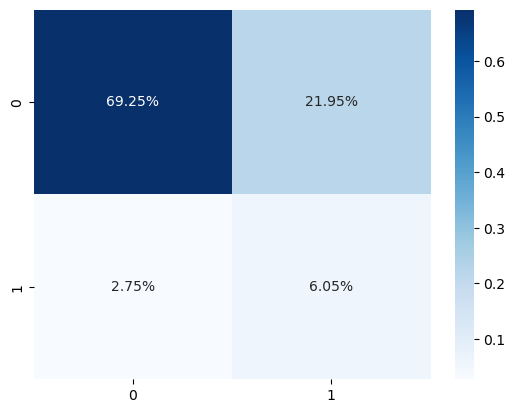

In [44]:
cf_matrix_rf_os = confusion_matrix(y_test, rf_grid_pred_os)
sns.heatmap(cf_matrix_rf_os/np.sum(cf_matrix_rf_os), annot=True, 
            fmt='.2%', cmap='Blues')

In [45]:
#train using best hyperparameters , test 
rf_os_2 = RandomForestClassifier(bootstrap = True, ccp_alpha = 0.0, 
                                 class_weight = None, criterion = 'entropy', 
                                 max_depth = 15, max_features = 'sqrt',
                                 max_leaf_nodes = None, max_samples = None,
                                 min_impurity_decrease= 0.0, min_samples_leaf = 1,
                                 min_samples_split = 5, min_weight_fraction_leaf = 0.0,
                                 n_estimators = 300, n_jobs = None, oob_score = False,
                                 random_state= None, verbose = 0, warm_start = False)



rf_os_2.fit(X_train_rs_ns, y_train_rs_ns)
rf_pred_os_2 = rf_os_2.predict(X_test)

rf_acc_os = rf_os_2.score(X_test, y_test)
rf_precision_os= precision_score(y_test, rf_pred_os_2)
rf_recall_os = recall_score(y_test, rf_pred_os_2)
rf_f1_os = f1_score(y_test, rf_pred_os_2)

rf_fpr_os, rf_tpr_os, rf_thresholds_os = roc_curve(y_test, rf_os_2.predict_proba(X_test)[:,1])
roc_auc_rf_os = auc(rf_fpr_os,rf_tpr_os)

print(f'Random Forest (Test) Oversampling: Accuracy: {rf_acc_os:.6f}')
print(f'Random Forest (Test) Oversampling: Precision: {rf_precision_os:.6f}')
print(f'Random Forest (Test) Oversampling: Recall : {rf_recall_os:.6f}')
print(f'Random Forest (Test) Oversampling: F1 : {rf_f1_os:.6f}')
print(f'Random Forest (Test) Oversampling: Roc : {roc_auc_rf_os:.6f}')

Random Forest (Test) Oversampling: Accuracy: 0.753745
Random Forest (Test) Oversampling: Precision: 0.216506
Random Forest (Test) Oversampling: Recall : 0.686742
Random Forest (Test) Oversampling: F1 : 0.329220
Random Forest (Test) Oversampling: Roc : 0.803013


Random Forest 1c. SMOTE + RandomizedSearchCV 

In [46]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

imb_ratio = int(n_neg/n_pos)
ratio = {1 : n_pos * imb_ratio, 0 : n_neg} 

smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
   
X_train_smote_ns, y_train_smote_ns = smote.fit_resample(X_train, y_train)

In [59]:
grid_values_rf = {
    'bootstrap': [True, False],
    'min_samples_leaf': [1,2,4,8],
    'min_samples_split' : [2,4,5,10],
    'max_depth': [5,10,15,20],
    'n_estimators': [10, 50, 100, 150, 200, 300]}


rf_smote = RandomForestClassifier()
grid_rf_smote_2 = RandomizedSearchCV(rf_smote, param_distributions = grid_values_rf,
                                    cv=3, scoring=['precision','recall','f1', 'roc_auc'],
                                    n_jobs= -1, verbose = 2, refit = 'recall',
                                    return_train_score = True, 
                                    n_iter = 10)
grid_rf_smote_2.fit(X_train_smote_ns, y_train_smote_ns)

rf_grid_pred_smote_2 = grid_rf_smote_2.predict(X_test)
rf_grid_best_para_smote_2= grid_rf_smote_2.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  40.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  32.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  31.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time= 1.5min
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time= 1.3min
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time= 3.2min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 3.0min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  34.5s
[CV]

In [60]:
print(grid_rf_smote_2.best_estimator_.get_params())

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [61]:
print(classification_report(y_test, rf_grid_pred_smote_2))

              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91    104283
         1.0       0.27      0.45      0.34     10062

    accuracy                           0.85    114345
   macro avg       0.61      0.67      0.63    114345
weighted avg       0.88      0.85      0.86    114345



<AxesSubplot:>

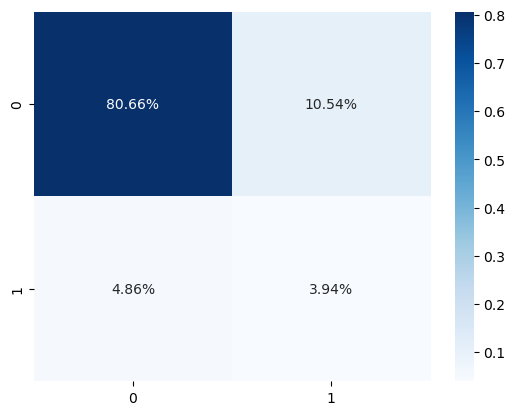

In [62]:
cf_matrix_rf_smote_2 = confusion_matrix(y_test, rf_grid_pred_smote_2)
sns.heatmap(cf_matrix_rf_smote_2/np.sum(cf_matrix_rf_smote_2), annot=True, 
            fmt='.2%', cmap='Blues')

In [47]:
grid_values_rf = {
    'bootstrap': [True, False],
    'min_samples_leaf': [1,2,4,8],
    'min_samples_split' : [2,4,5,10],
    'max_depth': [5,10,15,20],
    'criterion': ['gini','entropy'], 
    'n_estimators': [10, 50, 100, 150, 200, 300]}


rf_smote = RandomForestClassifier()
grid_rf_smote = RandomizedSearchCV(rf_smote, param_distributions = grid_values_rf,
                                    cv=3, scoring=['precision','recall','f1', 'roc_auc'],
                                    n_jobs= -1, verbose = 2, refit = 'recall',
                                    return_train_score = True, random_state = 42, 
                                    n_iter = 10)
grid_rf_smote.fit(X_train_smote_ns, y_train_smote_ns)

rf_grid_pred_smote = grid_rf_smote.predict(X_test)
rf_grid_best_para_smote = grid_rf_smote.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [48]:
print(rf_grid_best_para_smote)

{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'criterion': 'gini', 'bootstrap': False}


In [49]:
rf_grid_best_estimator_smote = grid_rf_smote.best_estimator_
print(rf_grid_best_estimator_smote)

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=150)


In [50]:
print(grid_rf_smote.best_estimator_.get_params())

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [51]:
print(classification_report(y_test, rf_grid_pred_smote))

              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93    104283
         1.0       0.28      0.33      0.31     10062

    accuracy                           0.87    114345
   macro avg       0.61      0.63      0.62    114345
weighted avg       0.88      0.87      0.87    114345



<AxesSubplot:>

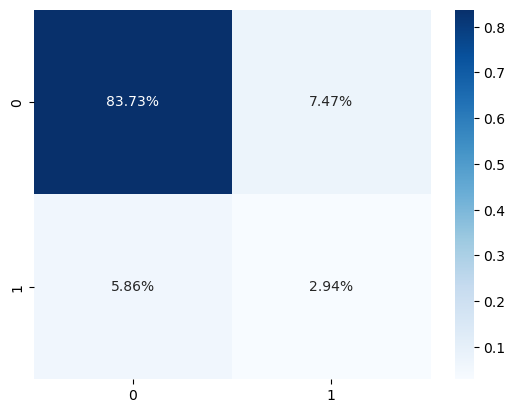

[CV] END bootstrap=False, criterion=gini, max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 3.4min
[CV] END bootstrap=False, criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 2.9min
[CV] END bootstrap=False, criterion=gini, max_depth=20, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time= 1.8min
[CV] END bootstrap=False, criterion=gini, max_depth=15, min_samples_leaf=8, min_samples_split=5, n_estimators=10; total time=  12.2s
[CV] END bootstrap=False, criterion=gini, max_depth=15, min_samples_leaf=8, min_samples_split=5, n_estimators=10; total time=  10.8s
[CV] END bootstrap=False, criterion=gini, max_depth=15, min_samples_leaf=8, min_samples_split=5, n_estimators=10; total time=   9.9s
[CV] END bootstrap=True, criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  33.7s
[CV] END bootstrap=True, criterion=gini, max_depth=10, min_sam

In [52]:
cf_matrix_rf_smote = confusion_matrix(y_test, rf_grid_pred_smote)
sns.heatmap(cf_matrix_rf_smote/np.sum(cf_matrix_rf_smote), annot=True, 
            fmt='.2%', cmap='Blues')

In [63]:
#train using best hyperparameters , test 
rf_smote_2 = RandomForestClassifier(bootstrap = False, ccp_alpha = 0.0, 
                                    class_weight = None, criterion = 'entropy', 
                                    max_depth = 20, max_features = 'sqrt',
                                    max_leaf_nodes = None, max_samples = None,
                                    min_impurity_decrease = 0.0, min_samples_leaf = 2,
                                    min_samples_split = 5, min_weight_fraction_leaf = 0.0, 
                                    n_estimators = 150, n_jobs = None, oob_score = False, 
                                    random_state = None, verbose = 0, warm_start = False)


rf_smote_2.fit(X_train_smote_ns, y_train_smote_ns)
rf_pred_smote_2 = rf_smote_2.predict(X_test)

rf_acc_smote = rf_smote_2.score(X_test, y_test)
rf_precision_smote= precision_score(y_test, rf_pred_smote_2)
rf_recall_smote = recall_score(y_test, rf_pred_smote_2)
rf_f1_smote = f1_score(y_test, rf_pred_smote_2)

rf_fpr_smote, rf_tpr_smote, rf_thresholds_smote = roc_curve(y_test, rf_smote_2.predict_proba(X_test)[:,1])
roc_auc_rf_smote = auc(rf_fpr_smote,rf_tpr_smote)

print(f'Random Forest (Test) SMOTE: Accuracy: {rf_acc_smote:.6f}')
print(f'Random Forest (Test) SMOTE: Precision: {rf_precision_smote:.6f}')
print(f'Random Forest (Test) SMOTE: Recall : {rf_recall_smote:.6f}')
print(f'Random Forest (Test) SMOTE: F1 : {rf_f1_smote:.6f}')
print(f'Random Forest (Test) SMOTE: Roc : {roc_auc_rf_smote:.6f}')

Random Forest (Test) SMOTE: Accuracy: 0.867515
Random Forest (Test) SMOTE: Precision: 0.284868
Random Forest (Test) SMOTE: Recall : 0.334725
Random Forest (Test) SMOTE: F1 : 0.307791
Random Forest (Test) SMOTE: Roc : 0.794651


XGBoost


1a. Class weight + RandomizedSearchCV

In [54]:
from collections import Counter
counter = Counter(y_train)
est= counter[0]/counter[1]
print(est)

10.36391515461283


In [ ]:
grid_values_xg = {'max_depth' : [ 3, 4, 5, 6, 8, 10, 12],
                  'min_child_weight' : [ 1,2,3,4,5,8]}


xgb_balanced =  XGBClassifier(scale_pos_weight = est)

grid_xg_weight = RandomizedSearchCV(xg_balanced, param_distributions = grid_values_xg,
                                    cv=3,
                                    scoring=['precision','recall','f1', 'roc_auc'],
                                    n_jobs= -1, refit = 'recall',
                                    return_train_score = True,  
                                    n_iter = 10)


grid_xg_weight.fit(X_train, y_train)


xg_grid_pred_weight = grid_xg_weight.predict(X_test)
xg_grid_best_para_weight = grid_xg_weight.best_params_

In [ ]:
print(xg_grid_best_para_weight)

In [ ]:
xg_grid_best_estimator_weight = grid_xg_weight.best_estimator_
print(xg_grid_best_estimator_weight)

In [ ]:
xg_grid_best_estimator_weight = grid_xg_weight.best_estimator_
print(xg_grid_best_estimator_weight)

In [ ]:
print(classification_report(y_test, xg_grid_pred_weight))

In [ ]:
cf_matrix_xg_weight = confusion_matrix(y_test, xg_grid_pred_weight)
sns.heatmap(cf_matrix_xg_weight/np.sum(cf_matrix_xg_weight), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
#train using best hyperparameters , test 
xg_weight_3 = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1)

xg_weight_3.fit(X_train, y_train)
xg_pred_weight_3 = xg_weight_3.predict(X_test)

xg_acc_weight = xg_weight_3.score(X_test, y_test)
xg_precision_weight= precision_score(y_test, xg_pred_weight_3)
xg_recall_weight = recall_score(y_test, xg_pred_weight_3)
xg_f1_weight = f1_score(y_test, xg_pred_weight_3)

xg_fpr_weight, xg_tpr_weight, xg_thresholds_weight = roc_curve(y_test, xg_weight_3.predict_proba(X_test)[:,1])
roc_auc_xg_weight = auc(xg_fpr_weight,xg_tpr_weight)

print(f'XGBoost (Test) Class Weight: Accuracy: {xg_acc_weight:.6f}')
print(f'XGBoost (Test) Class Weight: Precision: {xg_precision_weight:.6f}')
print(f'XGBoost (Test) Class Weight: Recall : {xg_recall_weight:.6f}')
print(f'XGBoost (Test) Class Weight: F1 : {xg_f1_weight:.6f}')
print(f'XGBoost (Test) Class Weight: Roc : {roc_auc_xg_weight:.6f}')


1b. Oversampling + RandomizedSearchCV

1c. SMOTE + RandomizedSearchCV

ROC Curve: Class Weights 

In [ ]:
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn.predict_proba(X_test_s)[:,1])
roc_auc_knn = auc(knn_fpr,knn_tpr )
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, lr.predict_proba(X_test_s)[:,1])
roc_auc_lr = auc(lr_fpr,lr_tpr )

plt.plot(knn_fpr, knn_tpr, c = 'orange', lw=2, label = f'knn, auc = {roc_auc_knn}')
plt.plot(lr_fpr, lr_tpr, c = 'red', lw=2, label = f'Logistic Regression, auc = {roc_auc_lr}')
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc = 'lower right')
plt.title('ROC curves');


In [ ]:
ROC Curve: Oversampling

In [ ]:
acc = [knn_acc,lr_acc]
precision = [knn_precision, lr_precision]
recall = [knn_recall, lr_recall]
f1 = [knn_f1, lr_f1]
auc = [roc_auc_knn, roc_auc_lr]

index_labels = ['knn', 'logistic regression']
zipped = list(zip(acc, precision, recall, f1, auc))
scores_df = pd.DataFrame(zipped, columns = ['accuracy', 'precision', 'recall', 
                                         'f1', 'auc'], index = index_labels)

scores_df